In [1]:
import sys
sys.path.append("../")

In [2]:
import os

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.random import set_seed
import tensorflow.keras.backend as K
from tensorflow.keras import activations
from pathlib import Path
from tensorflow.keras.layers import (
    Input,
    Activation,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    ELU,
    LeakyReLU,
    MaxPool2D,
    PReLU
)

from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
sys.path.append(os.path.dirname(os.getcwd()))
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import backend as K

from gradCAM import GradCAM, show_gradCAMs
from utils.predictions import evaluate_tp_tn_fp_fn, get_dataset_generators

WIDTH, HEIGHT = (256, 256)
BATCH_SIZE = 4
DATAGEN_SEED = 24
NUM_CLASSES = 29

set_seed(DATAGEN_SEED)

In [3]:
def modulus_activation(x):
    return K.abs(x)

In [4]:
kernel_initializer =  'he_uniform'

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer=kernel_initializer)(inputs)
    x = BatchNormalization()(x)
    # x = PReLU()(x)
    x = modulus_activation(x)
    # x = Activation(modulus_activation)(x)

    x = Conv2D(num_filters, 3, padding="same", kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = modulus_activation(x)
    # x = Activation(activations.gelu)(x)
    
    # x = Activation(modulus_activation)(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same", kernel_initializer=kernel_initializer)(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes=29):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    # s4, p4 = encoder_block(p3, 512)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    # d1 = decoder_block(b1, s4, 512)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(NUM_CLASSES, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

In [5]:
model = build_unet((HEIGHT, WIDTH, 3))
model.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=['accuracy', Recall(name="recall"), Precision(name="precision")])

In [6]:
model.load_weights('D:\mainD\study\cityscapes\modulus_model.hdf5')

In [7]:
models_names = os.listdir("D:\mainD\study\cityscapes\models")
unets = [
    load_model(os.path.join("D:\mainD\study\cityscapes\models", model_path))
    for model_path in models_names
]
models_names.append('modulus_model.hdf5')
unets.append(model)


In [12]:
_, val_set = get_dataset_generators(data_dir=Path('d:\mainD\study\cityscapes\dataset'), batch_size=2)

Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.


In [143]:
from collections import defaultdict
import dataclasses as dc
from functools import lru_cache
from json import dump
from pathlib import Path
from typing import Dict, List, Tuple
def calculate_cm_row(y_pred_argmax, y_true_argmax, class_idx):
    y_pred_argmax_class = y_pred_argmax == class_idx

    value_counts = np.unique(y_true_argmax[y_pred_argmax_class], return_counts=True)
    return value_counts
    

def evaluate_cm(model, val_set, name):
    """Val set's batch size is assumed to be 1."""
    confusion_matrix = np.zeros((NUM_CLASSES + 1, NUM_CLASSES + 1), dtype = "int")

    for i, (X, y_true) in enumerate(val_set, start=1):
        if i == 3:
            break
        y_pred = model.predict_on_batch(X)[0]
        y_true = y_true[0]
        y_pred_argmax = tf.argmax(y_pred, axis=-1)
        y_true_argmax = tf.argmax(y_true, axis=-1)

        for idx in range(NUM_CLASSES + 1):
            pred_class, value_counts = calculate_cm_row(y_pred_argmax, y_true_argmax, idx)
            confusion_matrix_row = np.zeros(NUM_CLASSES + 1, dtype = "int")
            confusion_matrix_row[pred_class] = value_counts
            confusion_matrix[idx] += confusion_matrix_row

    cm_sum = confusion_matrix.astype(np.float32).sum(axis=0)
    normalized_cm = np.array(confusion_matrix).astype(np.float32)
    
    normalized_cm[:, cm_sum != 0] = confusion_matrix[:,cm_sum != 0] /cm_sum[cm_sum != 0] 
    return (normalized_cm)

gelu_model.hdf5
leaky_relu_model.hdf5
mish_model.hdf5
swish_model.hdf5
modulus_model.hdf5


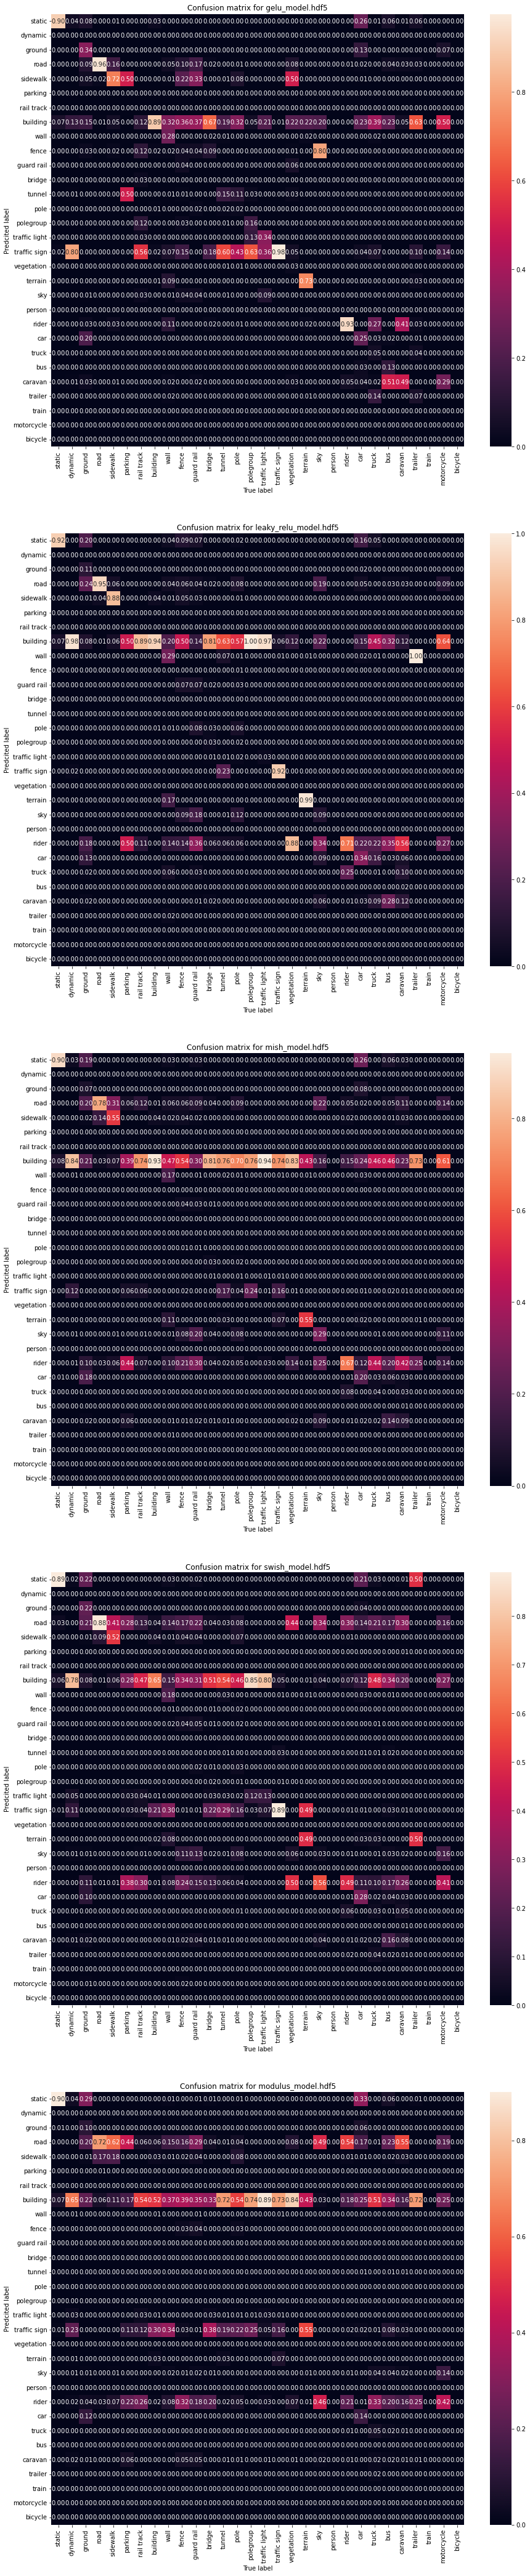

In [146]:
import seaborn as sns
from scripts.prepare_cityscapes_data import get_all_labels
from matplotlib.pyplot import figure


labels = get_all_labels()
labels = [label.name for label in labels][4:]
fig, axs=plt.subplots(len(models_names), figsize=(15, 75))
for model_name, model, ax in zip(models_names, unets, axs):
    print(model_name)
    cm = evaluate_cm(model, val_set, model_name)
    sns.heatmap(cm, ax=ax, xticklabels=labels, yticklabels=labels,annot=True, fmt=".2f")
    ax.set_ylabel("Predcited label")
    ax.set_xlabel("True label")
    ax.set_title(f"Confusion matrix for {model_name}")
plt.show()